#Install Dependencies


In [ ]:
!pip install happytransformer transformers librosa torch torchaudio nltk jiwer textblob pandas matplotlib seaborn scikit-learn speechrecognition bert_score spacy huggingface_hub[hf_xet]
!python -m spacy download en_core_web_sm

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 

In [ ]:
from typing import Dict, List, Union, Tuple

def inference(audio: str, pipeline_components: Dict = None) -> Dict:

    import spacy

    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        logger.info("spaCy model not found; downloading en_core_web_sm…")
        try:
            spacy.cli.download("en_core_web_sm")
        except SystemExit:
            pass

    audio = json.loads(audio)
    audio = np.array(audio, dtype=np.float32)
    GRAMMAR_MODEL = "vennify/t5-base-grammar-correction"
    WHISPER_MODEL = "openai/whisper-small"

    SAMPLE_RATE = 16000

    # Stricter scoring weights
    WEIGHTS = {
        'bert_score': 0.3,
        'error_rate': 0.4,        # Increased weight for errors
        'structural_score': 0.2,
        'grammatical_complexity': 0.1
    }

    def create_grammar_pipeline():
      try:
          pipeline_components = {
              'nlp': spacy.load('en_core_web_sm'),
              'grammar_model': HappyTextToText("T5", GRAMMAR_MODEL),
              'stt_model': transformers.pipeline(
                  "automatic-speech-recognition",
                  model=WHISPER_MODEL,
                  device=0 if torch.cuda.is_available() else -1
              ),
              'settings': TTSettings(num_beams=5, min_length=1)
          }
          return pipeline_components
      except Exception as e:
          logger.error(f"Pipeline creation failed: {str(e)}")
          raise {'error': str(e)}

    try:
        if pipeline_components is None:
            pipeline_components = create_grammar_pipeline()

        # Extract components
        nlp = pipeline_components['nlp']
        grammar_model = pipeline_components['grammar_model']
        stt_model = pipeline_components['stt_model']
        settings = pipeline_components['settings']

        # Configuration parameters
        config = {
            'sample_rate': SAMPLE_RATE,
            'weights': WEIGHTS
        }

        # Process audio
        sr = config['sample_rate']

        # Speech to text
        transcription = stt_model(audio)["text"]

        # Grammar correction
        grammar_input = f"grammar: {transcription}"
        corrected = grammar_model.generate_text(grammar_input, args=settings).text

        # Calculate metrics
        metrics = {}

        # BERTScore
        P, R, F1 = score([transcription], [corrected], lang='en')
        metrics['bert_score'] = F1.item()

        # Error rate
        error_rate = wer(corrected, transcription)
        metrics['error_rate'] = max(0, 1 - (error_rate * 1.5))

        # Structural and complexity analysis
        doc = nlp(corrected)

        print(doc)

        # Structural score
        features_struct = {
            'has_subject': any(token.dep_ == 'nsubj' for token in doc),
            'has_verb': any(token.pos_ == 'VERB' for token in doc),
            'has_punctuation': any(token.is_punct for token in doc),
            'has_proper_capitalization': doc[0].text[0].isupper() if len(doc) > 0 else False,
            'has_complete_sentence': bool(list(doc.sents))
        }
        metrics['structural_score'] = sum(features_struct.values()) / len(features_struct)

        # Complexity score
        features_complex = {
            'sentence_length': min(len(doc) / 20, 1.0),
            'verb_density': len([token for token in doc if token.pos_ == 'VERB']) / len(doc),
            'unique_pos_ratio': len(set(token.pos_ for token in doc)) / len(doc)
        }
        metrics['grammatical_complexity'] = sum(features_complex.values()) / len(features_complex)

        # Calculate final score
        weighted_score = sum(
            metrics.get(key, 0) * weight
            for key, weight in config['weights'].items()
        )
        base_score = weighted_score * 10

        # Apply penalties
        penalties = 0
        if metrics['error_rate'] < 0.8:
            penalties += (0.8 - metrics['error_rate']) * 6
        if metrics['bert_score'] < 0.97:
            penalties += (0.97 - metrics['bert_score']) * 4

        final_score = max(0.0, min(10.0, base_score - penalties))

        # Prepare results
        results = {
            'original_text': transcription,
            'corrected_text': corrected,
            'metrics': metrics,
            'grammar_score': round(final_score, 2),
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        return results

    except Exception as e:
        logger.error(f"Error checking grammar score: {str(e)}")
        return {'error': str(e)}

#Dependencies

#Testing

In [ ]:
class Config:
    """Configuration class for model settings"""
    # Model paths
    GRAMMAR_MODEL = "vennify/t5-base-grammar-correction"
    WHISPER_MODEL = "openai/whisper-small"

    # Audio settings
    SAMPLE_RATE = 16000

    # Stricter scoring weights
    WEIGHTS = {
        'bert_score': 0.3,
        'error_rate': 0.4,        # Increased weight for errors
        'structural_score': 0.2,
        'grammatical_complexity': 0.1
    }



class Utils:
    @staticmethod
    def safe_divide(a: float, b: float) -> float:
        """Safe division handling zero denominator"""
        return a / b if b != 0 else 0.0

    @staticmethod
    def normalize_score(score: float, min_val: float = 0.0, max_val: float = 1.0) -> float:
        """Normalize score to range [0,1]"""
        return max(min_val, min(max_val, score))

In [ ]:
class GrammarAnalysisEngine:
    def __init__(self):
        """Initialize models and components"""
        try:
            logger.info("Initializing Grammar Analysis Engine...")

            # Initialize NLP models
            self.nlp = spacy.load('en_core_web_sm')
            self.grammar_model = HappyTextToText("T5", Config.GRAMMAR_MODEL)

            # Corrected Whisper model initialization
            self.stt_model = transformers.pipeline(
                "automatic-speech-recognition",
                model=Config.WHISPER_MODEL,
                device=0 if torch.cuda.is_available() else -1
            )

            # Initialize settings
            self.settings = TTSettings(num_beams=5, min_length=1)

            # Suppress specific model warnings
            logging.getLogger("transformers").setLevel(logging.ERROR)

            logger.info("Initialization complete!")

        except Exception as e:
            logger.error(f"Initialization failed: {str(e)}")
            raise Exception(f"Failed to initialize models: {str(e)}")

    def process_audio(self, audio_path: str) -> Dict:
        """Process audio file and analyze grammar"""
        try:
            # Load audio with error checking
            if not os.path.exists(audio_path):
                raise FileNotFoundError(f"Audio file not found: {audio_path}")

            audio, sr = librosa.load(audio_path, sr=Config.SAMPLE_RATE)

            # Speech to text with enhanced error handling
            try:
                transcription_result = self.stt_model(audio)
                transcription = transcription_result["text"]
            except Exception as e:
                raise Exception(f"Speech recognition failed: {str(e)}")

            # Grammar correction with validation
            grammar_input = f"grammar: {transcription}"
            correction_result = self.grammar_model.generate_text(grammar_input, args=self.settings)

            if not correction_result or not correction_result.text:
                raise ValueError("Grammar correction failed to produce output")

            corrected_text = correction_result.text

            # Calculate metrics
            metrics = self.calculate_metrics(transcription, corrected_text)

            if not metrics:
                raise ValueError("Metrics calculation failed")

            return {
                'original_text': transcription,
                'corrected_text': corrected_text,
                'metrics': metrics,
                'grammar_score': self.calculate_final_score(metrics),
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }

        except Exception as e:
            logger.error(f"Error processing audio: {str(e)}")
            return {'error': str(e)}

    def calculate_final_score(self, metrics: Dict) -> float:
      try:
          if not metrics:
              return 0.0

          # Calculate base score
          weighted_score = sum(
              metrics.get(key, 0) * weight
              for key, weight in Config.WEIGHTS.items()
          )

          # Initial score out of 10
          base_score = weighted_score * 10

          # Apply penalties
          penalties = 0

          # Error rate penalties (stricter)
          error_score = metrics.get('error_rate', 0)
          if error_score < 0.8:
              penalties += (0.8 - error_score) * 6  # Increased penalty multiplier

          # Semantic difference penalties
          bert_score = metrics.get('bert_score', 0)
          if bert_score < 0.97:
              penalties += (0.97 - bert_score) * 4

          # Calculate score with penalties
          final_score = base_score - penalties

          # Score capping based on error severity
          if error_score < 0.6:  # Severe errors
              final_score = min(final_score, 5.0)
          elif error_score < 0.8:  # Moderate errors
              final_score = min(final_score, 6.5)
          elif error_score < 0.9:  # Minor errors
              final_score = min(final_score, 8.0)

          # Perfect grammar bonus (only if really perfect)
          if all(metrics.get(key, 0) > 0.98 for key in ['bert_score', 'error_rate']):
              final_score = max(final_score, 9.0)

          # Ensure score stays within bounds
          return round(max(0.0, min(10.0, final_score)), 2)

      except Exception as e:
          logger.error(f"Score calculation failed: {str(e)}")
          return 0.0

    def calculate_metrics(self, original_text: str, corrected_text: str) -> Dict:
        """Enhanced metrics calculation"""
        try:
            metrics = {}

            # BERTScore
            P, R, F1 = score([original_text], [corrected_text], lang='en')
            metrics['bert_score'] = F1.item()

            # Error rate calculation
            error_rate = wer(corrected_text, original_text)
            # Modified error rate that's more sensitive to errors
            metrics['error_rate'] = max(0, 1 - (error_rate * 1.5))  # More punishing for errors

            # Structural analysis
            doc = self.nlp(corrected_text)
            metrics['structural_score'] = self.analyze_structure(doc)

            # Grammar complexity
            metrics['grammatical_complexity'] = self.analyze_complexity(doc)

            # Count grammar errors
            error_count = len(self.identify_grammar_errors(original_text, corrected_text))
            metrics['error_count'] = error_count

            return metrics

        except Exception as e:
            logger.error(f"Metrics calculation failed: {str(e)}")
            return {}

    def identify_grammar_errors(self, original_text: str, corrected_text: str) -> List[str]:
        """Identify specific grammar errors"""
        errors = []
        original_words = original_text.split()
        corrected_words = corrected_text.split()

        # Basic error patterns
        error_patterns = {
            "don't has": "doesn't have",
            "no idea": "any idea",
            "were the": "was the",
            "not even try": "didn't even try"
        }

        for pattern, correction in error_patterns.items():
            if pattern in original_text:
                errors.append(f"Incorrect usage: '{pattern}' should be '{correction}'")

        return errors

    def analyze_structure(self, doc) -> float:
        """Optimized structural analysis"""
        try:
            features = {
                'has_subject': any(token.dep_ == 'nsubj' for token in doc),
                'has_verb': any(token.pos_ == 'VERB' for token in doc),
                'has_punctuation': any(token.is_punct for token in doc),
                'has_proper_capitalization': doc[0].text[0].isupper() if len(doc) > 0 else False,
                'has_complete_sentence': bool(list(doc.sents))
            }

            # All features present should result in a high score
            return sum(features.values()) / len(features)

        except Exception as e:
            logger.error(f"Structure analysis failed: {str(e)}")
            return 0.0

    def analyze_complexity(self, doc) -> float:
        """Simplified complexity analysis"""
        try:
            if len(doc) == 0:
                return 0.0

            features = {
                'sentence_length': min(len(doc) / 20, 1.0),  # More lenient length normalization
                'verb_density': len([token for token in doc if token.pos_ == 'VERB']) / len(doc),
                'unique_pos_ratio': len(set(token.pos_ for token in doc)) / len(doc)
            }

            return sum(features.values()) / len(features)

        except Exception as e:
            logger.error(f"Complexity analysis failed: {str(e)}")
            return 0.0

In [ ]:
class GrammarVisualizer:
    @staticmethod
    def plot_metrics(metrics: Dict):
        """Create visualization of metrics"""
        plt.figure(figsize=(12, 6))

        # Prepare data for plotting
        plot_metrics = {k: v for k, v in metrics.items() if isinstance(v, (int, float))}

        # Create bar plot
        bars = plt.bar(plot_metrics.keys(), plot_metrics.values())
        plt.xticks(rotation=45, ha='right')
        plt.title('Grammar Analysis Metrics')
        plt.ylabel('Score')

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

        plt.tight_layout()
        return plt

    @staticmethod
    def plot_grammar_score_gauge(score: float):
        """Create a gauge chart for grammar score"""
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

        # Convert score to percentage
        score_pct = score / 10

        # Create gauge
        ang_range, mid_pts = np.linspace(0, 180, 4), np.linspace(0, 180, 100)

        # Color gradient
        colors = plt.cm.RdYlGn(mid_pts/180.0)

        # Plot gauge background
        ax.bar(np.deg2rad(mid_pts), [1]*len(mid_pts),
               width=np.deg2rad(180/len(mid_pts)),
               bottom=0.0, color=colors, alpha=0.5)

        # Plot score marker
        ax.bar(np.deg2rad(180 * score_pct), 1,
               width=np.deg2rad(8), bottom=0.0,
               color='black', alpha=0.8)

        # Customize gauge
        ax.set_theta_direction(-1)
        ax.set_theta_offset(np.pi/2.0)
        ax.set_thetamin(0)
        ax.set_thetamax(180)

        plt.title(f'Grammar Score: {score}/10', pad=20)
        return plt

In [ ]:
class ResultsProcessor:
    def __init__(self):
        self.visualizer = GrammarVisualizer()

    def process_and_display_results(self, results: Dict):
        """Process and display analysis results"""
        if 'error' in results:
            print(f"Error in analysis: {results['error']}")
            return

        print("\n=== Grammar Analysis Report ===")
        print(f"Timestamp: {results['timestamp']}")

        print("\n1. Text Analysis:")
        print(f"Original: {results['original_text']}")
        print(f"Corrected: {results['corrected_text']}")

        print(f"\n2. Grammar Score: {results['grammar_score']}/10")

        print("\n3. Detailed Metrics:")
        for metric, value in results['metrics'].items():
            print(f"• {metric.replace('_', ' ').title()}: {value:.4f}")

        # Create visualizations
        print("\n4. Generating visualizations...")
        self.visualizer.plot_metrics(results['metrics'])
        plt.show()

        self.visualizer.plot_grammar_score_gauge(results['grammar_score'])
        plt.show()

        # Save results
        self.save_results(results)

    def save_results(self, results: Dict):
        """Save results to file"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'grammar_analysis_{timestamp}.json'

        with open(filename, 'w') as f:
            json.dump(results, f, indent=4)

        print(f"\nResults saved to {filename}")

=== Grammar Scoring Engine ===
Please upload an audio file for analysis...


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Saving He doesn't like it when people talk loudly during a movie; it's annoying..mp3 to He doesn't like it when people talk loudly during a movie; it's annoying..mp3


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]


=== Grammar Analysis Report ===
Timestamp: 2025-05-04 10:24:27

1. Text Analysis:
Original:  He doesn't like it when people talk loudly during a movie. It is annoying.
Corrected: He doesn't like it when people talk loudly during a movie. It is annoying.

2. Grammar Score: 9.54/10

3. Detailed Metrics:
• Bert Score: 1.0000
• Error Rate: 1.0000
• Structural Score: 1.0000
• Grammatical Complexity: 0.5382
• Error Count: 0.0000

4. Generating visualizations...


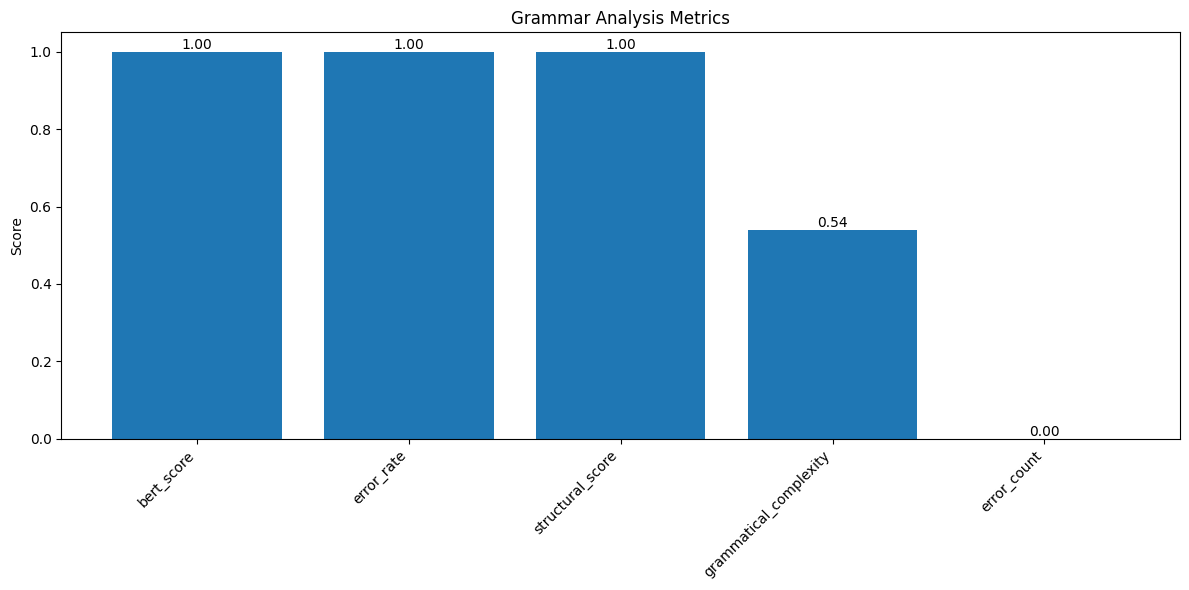

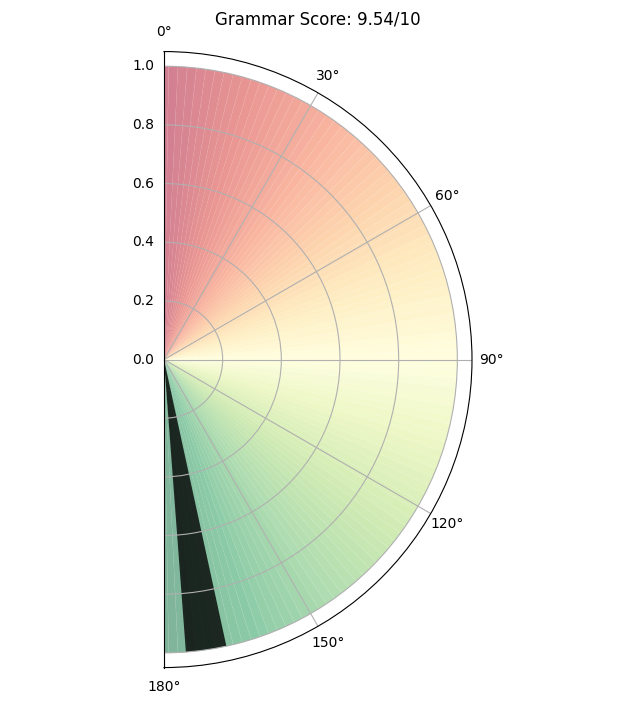


Results saved to grammar_analysis_20250504_102427.json


In [ ]:
def main():
    print("=== Grammar Scoring Engine ===")
    print("Please upload an audio file for analysis...")

    try:
        # Initialize engine and processor
        engine = GrammarAnalysisEngine()
        processor = ResultsProcessor()

        # Handle file upload
        uploaded = files.upload()

        if not uploaded:
            print("No file uploaded!")
            return

        # Process the first uploaded file
        audio_filename = list(uploaded.keys())[0]

        # Save the file temporarily
        with open(audio_filename, 'wb') as f:
            f.write(uploaded[audio_filename])

        # Process audio and display results
        results = engine.process_audio(audio_filename)
        processor.process_and_display_results(results)

    except Exception as e:
        print(f"Error in main execution: {e}")
    finally:
        # Cleanup
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

=== Grammar Scoring Engine ===
Please upload an audio file for analysis...


Saving He don't likes when people talks loudly during a movie, its annoying.mp3 to He don't likes when people talks loudly during a movie, its annoying.mp3

=== Grammar Analysis Report ===
Timestamp: 2025-05-04 10:25:20

1. Text Analysis:
Original:  He don't likes when people talk loudly during a movie, it's unknowing.
Corrected: He doesn't likes when people talk loudly during a movie, it's unknowing.

2. Grammar Score: 8.0/10

3. Detailed Metrics:
• Bert Score: 0.9862
• Error Rate: 0.8750
• Structural Score: 1.0000
• Grammatical Complexity: 0.5375
• Error Count: 0.0000

4. Generating visualizations...


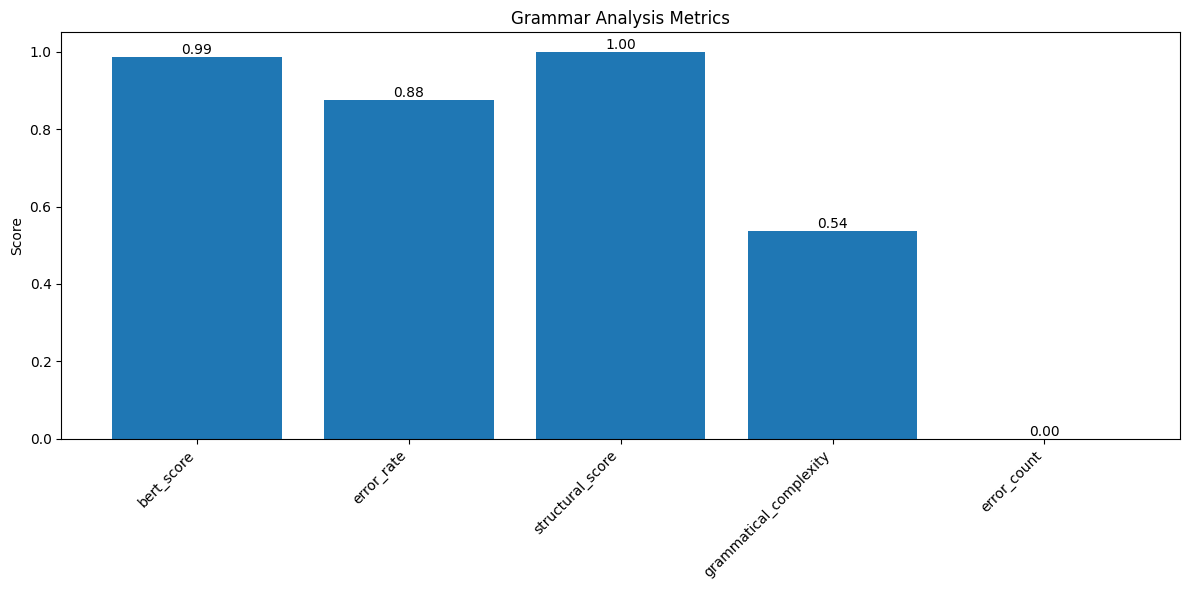

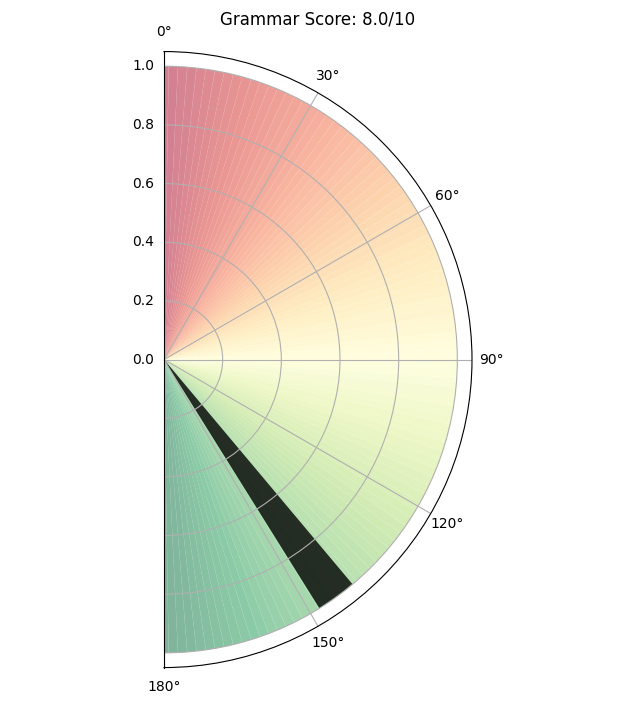


Results saved to grammar_analysis_20250504_102520.json


In [ ]:
main()

=== Grammar Scoring Engine ===
Please upload an audio file for analysis...


Saving She goes to the store yesterday and buyed many thing for hers childrens.mp3 to She goes to the store yesterday and buyed many thing for hers childrens.mp3

=== Grammar Analysis Report ===
Timestamp: 2025-05-04 10:26:06

1. Text Analysis:
Original:  She goes to the store yesterday and buys many things for her children's.
Corrected: She went to the store yesterday and bought many things for her children.

2. Grammar Score: 6.5/10

3. Detailed Metrics:
• Bert Score: 0.9785
• Error Rate: 0.6538
• Structural Score: 1.0000
• Grammatical Complexity: 0.4714
• Error Count: 0.0000

4. Generating visualizations...


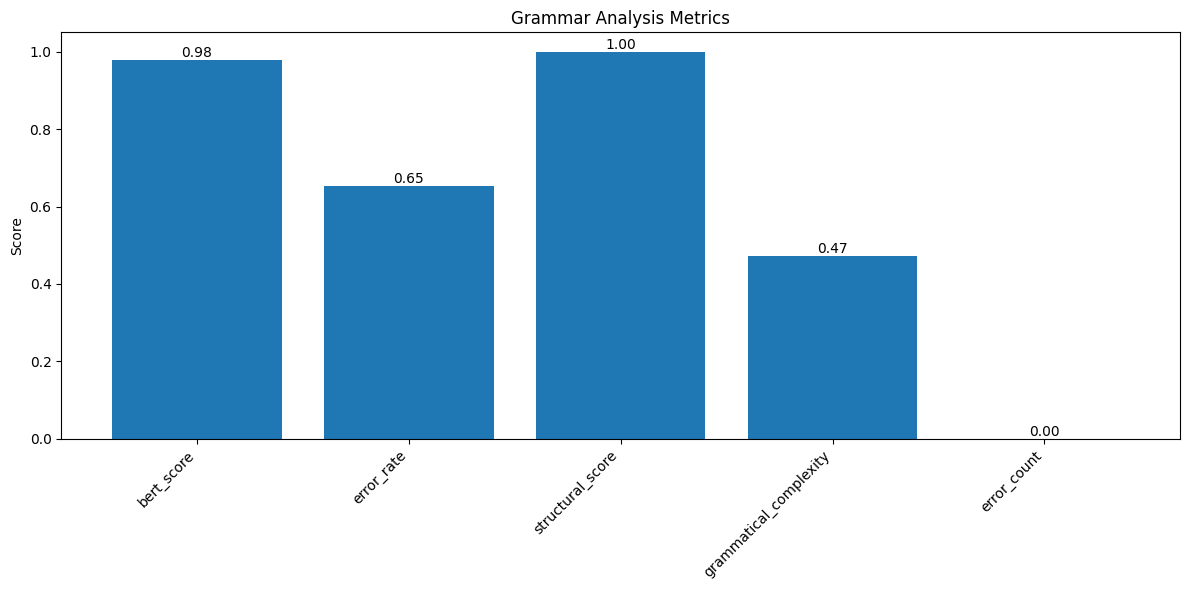

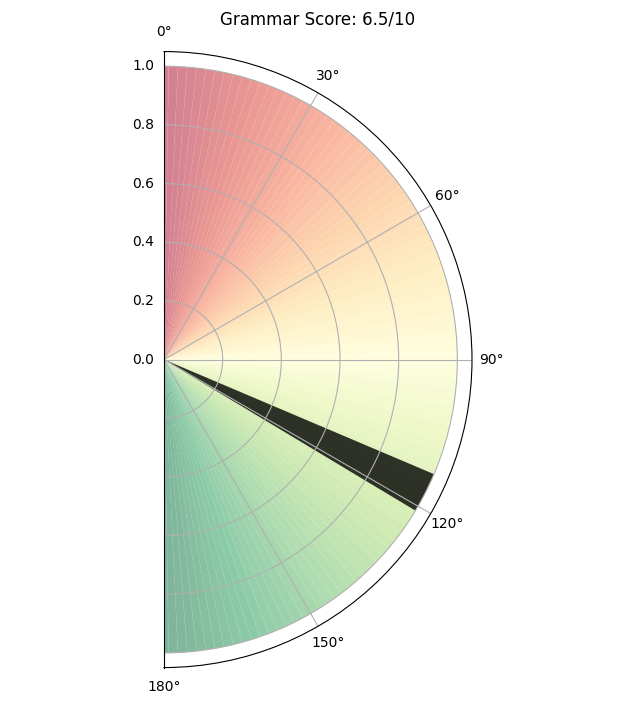


Results saved to grammar_analysis_20250504_102607.json


In [ ]:
main()

#Modelbit Deployment

In [ ]:
!python -m spacy download en_core_web_sm

!pip install happytransformer
!pip install librosa
!pip install torch torchvision torchaudio
!pip install transformers
!pip install bert-score
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from typing import Dict, List, Union, Tuple
from datetime import datetime
import logging
import spacy
from happytransformer import HappyTextToText, TTSettings
import librosa
import torch
import transformers
from bert_score import score
from jiwer import wer
import warnings
import numpy as np

#Storing Model to the Modelbit Register

In [ ]:
!pip install modelbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import modelbit
mb = modelbit.login()

In [ ]:
nlp =  spacy.load('en_core_web_sm')

In [ ]:
mb.add_model(name="spacy_eng", model=nlp)

Updating registry: 100%|██████████| 1/1 [00:02<00:00]


In [ ]:
from typing import Dict, List, Union, Tuple

def inference(audio: str, pipeline_components: Dict = None) -> Dict:

    import modelbit as mb
    from happytransformer import HappyTextToText, TTSettings
    import torch
    import transformers

    logger = logging.getLogger(__name__)
    logging.basicConfig(level=logging.INFO)

    audio = json.loads(audio)
    audio = np.array(audio, dtype=np.float32)
    GRAMMAR_MODEL = "vennify/t5-base-grammar-correction"
    WHISPER_MODEL = "openai/whisper-small"

    # Audio settings
    SAMPLE_RATE = 16000

    # Stricter scoring weights
    WEIGHTS = {
        'bert_score': 0.3,
        'error_rate': 0.4,        # Increased weight for errors
        'structural_score': 0.2,
        'grammatical_complexity': 0.1
    }

    def create_grammar_pipeline():
      try:
          pipeline_components = {
              'nlp': mb.get_model("spacy_eng"),
              'grammar_model': HappyTextToText("T5", GRAMMAR_MODEL),
              'stt_model': transformers.pipeline(
                  "automatic-speech-recognition",
                  model=WHISPER_MODEL,
                  device=0 if torch.cuda.is_available() else -1
              ),
              'settings': TTSettings(num_beams=5, min_length=1)
          }
          return pipeline_components
      except Exception as e:
          logger.error(f"Pipeline creation failed: {str(e)}")
          raise

    try:
        if pipeline_components is None:
            pipeline_components = create_grammar_pipeline()

        # Extract components
        nlp = pipeline_components['nlp']
        grammar_model = pipeline_components['grammar_model']
        stt_model = pipeline_components['stt_model']
        settings = pipeline_components['settings']

        # Configuration parameters
        config = {
            'sample_rate': SAMPLE_RATE,
            'weights': WEIGHTS
        }

        # Process audio
        sr = config['sample_rate']

        # Speech to text
        transcription = stt_model(audio)["text"]

        # Grammar correction
        grammar_input = f"grammar: {transcription}"
        corrected = grammar_model.generate_text(grammar_input, args=settings).text

        # Calculate metrics
        metrics = {}

        # BERTScore
        P, R, F1 = score([transcription], [corrected], lang='en')
        metrics['bert_score'] = F1.item()

        # Error rate
        error_rate = wer(corrected, transcription)
        metrics['error_rate'] = max(0, 1 - (error_rate * 1.5))

        # Structural and complexity analysis
        doc = nlp(corrected)

        # Structural score
        features_struct = {
            'has_subject': any(token.dep_ == 'nsubj' for token in doc),
            'has_verb': any(token.pos_ == 'VERB' for token in doc),
            'has_punctuation': any(token.is_punct for token in doc),
            'has_proper_capitalization': doc[0].text[0].isupper() if len(doc) > 0 else False,
            'has_complete_sentence': bool(list(doc.sents))
        }
        metrics['structural_score'] = sum(features_struct.values()) / len(features_struct)

        # Complexity score
        features_complex = {
            'sentence_length': min(len(doc) / 20, 1.0),
            'verb_density': len([token for token in doc if token.pos_ == 'VERB']) / len(doc),
            'unique_pos_ratio': len(set(token.pos_ for token in doc)) / len(doc)
        }
        metrics['grammatical_complexity'] = sum(features_complex.values()) / len(features_complex)

        # Calculate final score
        weighted_score = sum(
            metrics.get(key, 0) * weight
            for key, weight in config['weights'].items()
        )
        base_score = weighted_score * 10

        # Apply penalties
        penalties = 0
        if metrics['error_rate'] < 0.8:
            penalties += (0.8 - metrics['error_rate']) * 6
        if metrics['bert_score'] < 0.97:
            penalties += (0.97 - metrics['bert_score']) * 4

        final_score = max(0.0, min(10.0, base_score - penalties))

        # Prepare results
        results = {
            'original_text': transcription,
            'corrected_text': corrected,
            'metrics': metrics,
            'grammar_score': round(final_score, 2),
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        return results

    except Exception as e:
        logger.error(f"Inference failed: {str(e)}")
        return {'error': str(e)}

In [ ]:
import io

In [ ]:
audio_path = '/content/aud2.mp3'
files = {'file': open(audio_path, 'rb')}
audio, sr = librosa.load(files['file'], sr=16000)

In [ ]:
# Initialize once
audio = json.dumps(audio.tolist())
results = inference(audio)

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Device set to use cpu
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
results

{'original_text': " He doesn't like it when people talk loudly during a movie. It is annoying.",
 'corrected_text': "He doesn't like it when people talk loudly during a movie. It is annoying.",
 'metrics': {'bert_score': 0.9999998807907104,
  'error_rate': 1.0,
  'structural_score': 1.0,
  'grammatical_complexity': 0.538235294117647},
 'grammar_score': 9.54,
 'timestamp': '2025-05-05 04:40:12'}

In [ ]:
audio.tolist()

[3.552713678800501e-15,
 1.2434497875801753e-14,
 4.884981308350689e-15,
 6.661338147750939e-15,
 1.1546319456101628e-14,
 -4.440892098500626e-15,
 -6.217248937900877e-15,
 -7.105427357601002e-15,
 1.7763568394002505e-15,
 2.842170943040401e-14,
 4.440892098500626e-16,
 0.0,
 3.552713678800501e-15,
 -1.1546319456101628e-14,
 2.6645352591003757e-14,
 7.105427357601002e-15,
 3.552713678800501e-15,
 2.1316282072803006e-14,
 -3.6637359812630166e-15,
 -3.9968028886505635e-15,
 2.6645352591003757e-14,
 0.0,
 7.105427357601002e-15,
 6.217248937900877e-15,
 -1.1546319456101628e-14,
 1.4210854715202004e-14,
 -1.7763568394002505e-14,
 -1.7763568394002505e-15,
 1.7763568394002505e-15,
 1.3322676295501878e-14,
 0.0,
 -1.2434497875801753e-14,
 -7.549516567451064e-15,
 -2.2426505097428162e-14,
 -8.992806499463768e-15,
 2.9531932455029164e-14,
 1.587618925213974e-14,
 1.7763568394002505e-15,
 4.107825191113079e-15,
 -5.329070518200751e-15,
 1.1268763699945339e-14,
 -1.2545520178264269e-14,
 -8.437694

In [ ]:
!pip install modelbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import modelbit
mb = modelbit.login()

In [ ]:
mb.deploy(inference, python_packages=[
    'transformers==4.34.1',
    'sentencepiece==0.1.96',
    'spacy==3.7.2',
    'happytransformer==2.4.1',
    'librosa==0.10.1',
    'torch==2.1.2',
    'bert-score==0.3.13',
    'jiwer==3.0.3'
] , system_packages=["git", "cmake", "pkg-config"])

create_grammar_pipeline
<genexpr>
<genexpr>
<genexpr>
<listcomp>
<genexpr>
<genexpr>


#Testing Endpoint

In [ ]:
import json
import requests

res = requests.post(
    "https://keerthikeswaranks.us-east-1.aws.modelbit.com/v1/inference/latest",
    headers={"Content-Type": "application/json"},
    data=json.dumps({"data": audio})
)

In [ ]:
decoded_content = res.content.decode('utf-8')

In [ ]:
data_dict = json.loads(decoded_content)

In [ ]:
data_dict

{'data': {'original_text': " He doesn't like it when people talk loudly during a movie. It is annoying.",
  'corrected_text': "He doesn't like it when people talk loudly during a movie. It is annoying.",
  'metrics': {'bert_score': 1,
   'error_rate': 1,
   'structural_score': 1,
   'grammatical_complexity': 0.538235294117647},
  'grammar_score': 9.54,
  'timestamp': '2025-05-05 04:47:51'}}

In [ ]:
data_dict['data']['original_text']

" He doesn't like it when people talk loudly during a movie. It is annoying."

In [ ]:
## API ENDPOINT: https://keerthikeswaranks.us-east-1.aws.modelbit.com/v1/inference/latest